In [1]:
words = open('data/names.txt', 'r').read().splitlines()

In [2]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
b = {}
for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1

In [4]:
sorted(b.items(), key = lambda kv: -kv[1])

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('<S>', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '<E>'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('<S>', 'j'), 2422),
 (('o', 'n'), 2411),
 (('h', '<E>'), 2409),
 (('r', 'a'), 2356),
 (('a', 'h'), 2332),
 (('h', 'a'), 2244),
 (('y', 'a'), 2143),
 (('i', 'n'), 2126),
 (('<S>', 's'), 2055),
 (('a', 'y'), 2050),
 (('y', '<E>'), 2007),
 (('e', 'r'), 1958),
 (('n', 'n'), 1906),
 (('y', 'n'), 1826),
 (('k', 'a'), 1731),
 (('n', 'i'), 1725),
 (('r', 'e'), 1697),
 (('<S>', 'd'), 1690),
 (('i', 'e'), 1653),
 (('a', 'i'), 1650),
 (('<S>', 'r'), 1639),
 (('a', 'm'), 1634),
 (('l', 'y'), 1588),
 (('<S>', 'l'), 1572),
 (('<S>', 'c'), 1542),
 (('<S>', 'e'), 1531),
 (('j', 'a'), 1473),
 (

In [5]:
import torch

In [6]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0;
itos = {i:s for s,i in stoi.items()}

In [7]:
N = torch.zeros((27, 27), dtype=torch.int32)
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]; ix2 = stoi[ch2]
        N[ix1, ix2] += 1  

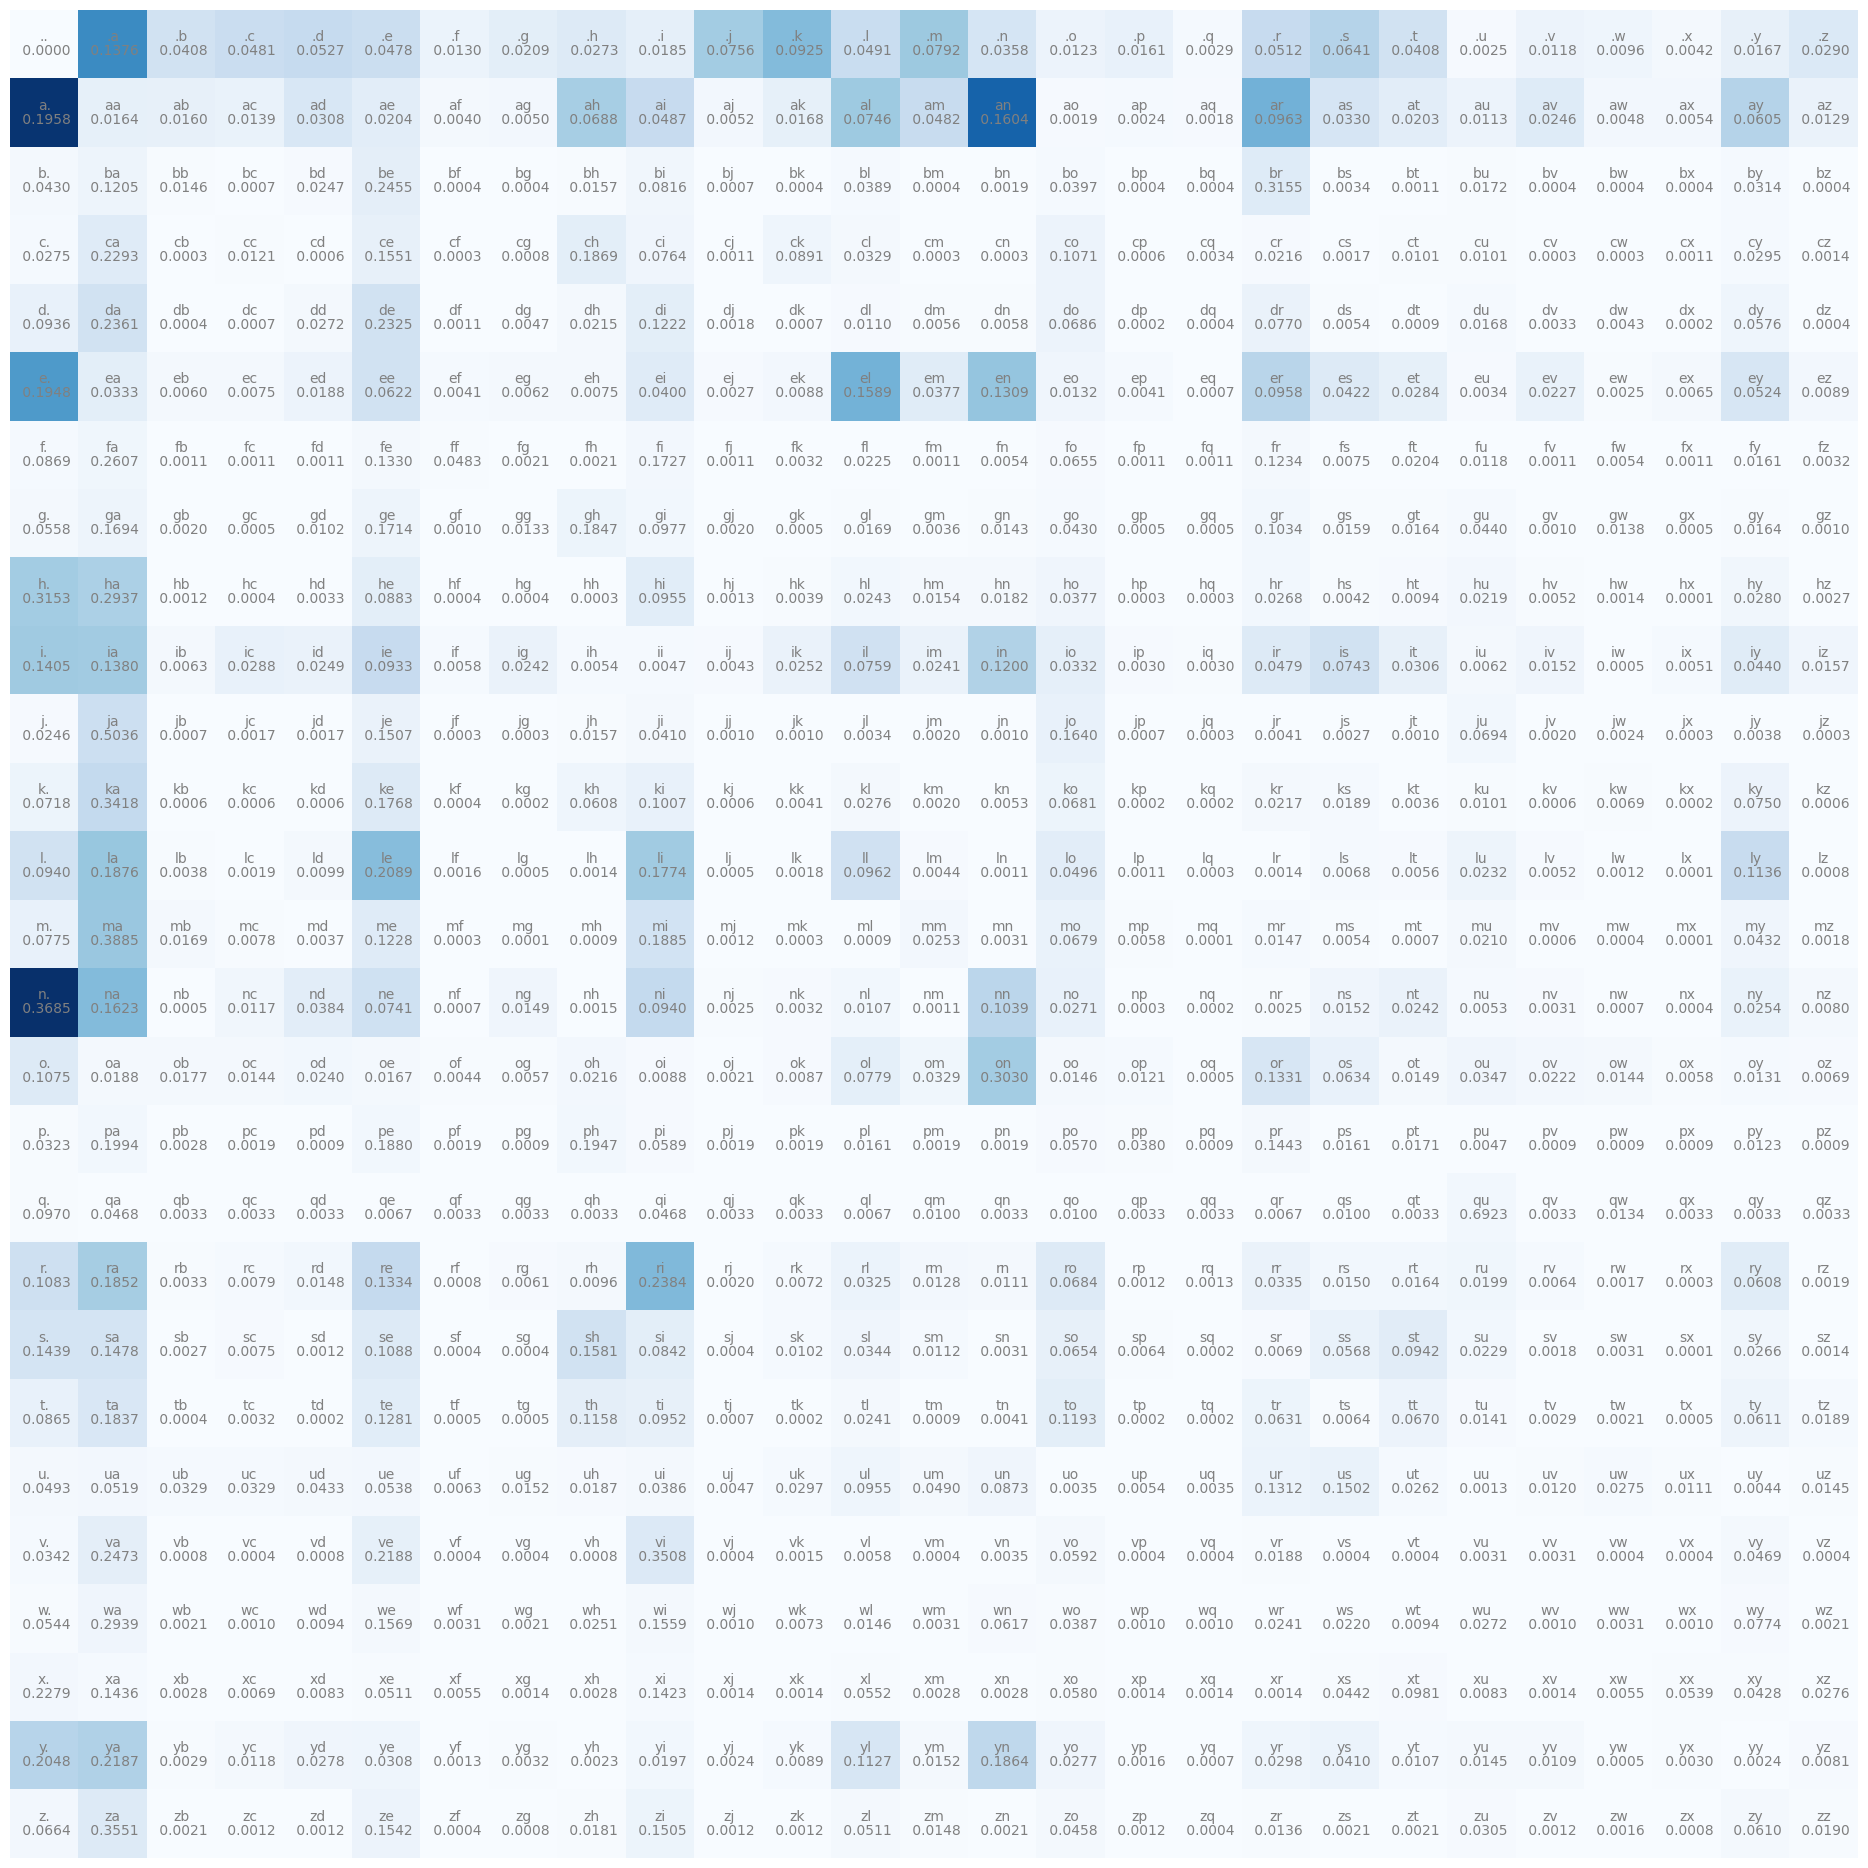

In [106]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(24, 24))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, f'{P[i, j].item(): .4f}', ha="center", va="top", color="gray")
plt.axis('off');

In [9]:
N[0]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

In [10]:
p = N[0].float()
p = p / p.sum()
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [11]:
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[ix]

'c'

In [48]:
g = torch.Generator().manual_seed(2147483647)
p = torch.rand(3, generator=g)
p = p / p.sum()
torch.multinomial(p, num_samples=1, replacement=True, generator=g)

tensor([0])

In [102]:
# currently we have a problem where pairs that don't exist in the training set
# have a probability of 0, which causes problems later on.
# add some fake counts to every pair before calculating probabilities
# semantically this means pairs like 'jq' become "very unlikely" rather than "impossible"
# this is called **model smoothing**

# the more we add, the "smoother" the output distribution will become
# adding 1 here works to get rid of our infinities later on, and preserves the peaks of our distribution
# (does this mean we lose information? seems like the model will be less useful if we add, say, 32k)
P = (N+1).float()

# 27x27 / 27x1 -> broadcastable, the operation is valid
# broadcasting (as in, a dimension may be "cast broadly" to match the dimension of the other tensor)
# allows memory management / copying to happen in C, which will be more efficient.
# it seems python with pytorch is more like a handle into fast-running native bindings rather than
# purely running in the relatively slow interpreter.
P /= P.sum(dim=1, keepdim=True) # /= is better than = / here, more memory efficient.

In [103]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
    out = []
    ix = 0
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        char = itos[ix]
        out.append(char)
        if char == '.':
            # end of word
            break
    print(''.join(out))

cexze.
momasurailezitynn.
konimittain.
llayn.
ka.


In [105]:
# we want to use maximum likelihood(!) estimation to evaluate how good our model output is
# we multiply all the probabilities of the individual bigrams and try to maximise this value.

# in practice, we take the natural log of the product of our probabilities
# log(a*b*c) = log(a) + log(b) + log(c)
# so we can sum the log-probabilities to find the output of our function

# log is a monotonic function (monotonically increasing along the x-axis)
# which means it preserves maxima of the original function

log_likelihood = 0.0
n = 0
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        # print(f'{ch1}{ch2}: {prob: .4f} {logprob: . 4f}')

print(f'{log_likelihood=}')
# to turn this into a loss function (i.e. something we can *minimize*), we just take the negative
nll = -log_likelihood
print(f'{nll=}')

# we can normalize this by taking the average, minimizing this value is equivalent to minimizing the nll
normalized_loss = nll / n
print(f'{normalized_loss=}')

log_likelihood=tensor(-559951.5625)
nll=tensor(559951.5625)
normalized_loss=tensor(2.4544)


In [245]:
xs, ys = [], []

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [246]:
import torch.nn.functional as F

xenc = F.one_hot(xs, num_classes=27).float()
yenc = F.one_hot(ys, num_classes=27).float()


In [247]:
W = torch.randn((27, 27), requires_grad=True) # single-layer neural network. 27 inputs, 27 outputs

In [248]:
# we interpret the output as the log of the counts of particular bigrams
# otherwise known as 'logits'
# then exponentiate to get actual counts
logits = (xenc @ W)
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
# we need to pluck out the probabilities corresponding to ys (the labels for the training data)
# i.e. [0, ys[0]], [1, ys[1], and so on
initial_loss = -probs[torch.arange(len(ys)), ys].log().mean()
print(f'{initial_loss=}')

initial_loss=tensor(3.8044, grad_fn=<NegBackward0>)


In [250]:
# backward pass
W.grad = None # more efficient than setting it to 0 in pytorch
initial_loss.backward()

In [251]:
# gradient descent step
W.data -= 0.1 * W.grad

In [254]:
# Now, in a training loop:
for k in range(100):
    # forward pass
    logits = (xenc @ W)
    counts = logits.exp()                         # softmax
    probs = counts / counts.sum(1, keepdims=True) # softmax
    loss = -probs[torch.arange(len(ys)), ys].log().mean() + 0.01*(W**2).mean()
    print(f'loss={loss.item()}')

    # backward pass
    W.grad = None
    loss.backward()

    # update params
    W.data -= 50 * W.grad

loss=2.4834794998168945
loss=2.483448028564453
loss=2.483417510986328
loss=2.4833872318267822
loss=2.4833576679229736
loss=2.483328342437744
loss=2.483299493789673
loss=2.4832711219787598
loss=2.483242988586426
loss=2.48321533203125
loss=2.483187675476074
loss=2.4831604957580566
loss=2.4831340312957764
loss=2.483107328414917
loss=2.483081817626953
loss=2.48305606842041
loss=2.4830305576324463
loss=2.4830057621002197
loss=2.482980966567993
loss=2.482956886291504
loss=2.4829330444335938
loss=2.4829092025756836
loss=2.4828858375549316
loss=2.482862710952759
loss=2.482839822769165
loss=2.4828174114227295
loss=2.482795238494873
loss=2.4827730655670166
loss=2.4827516078948975
loss=2.4827301502227783
loss=2.4827091693878174
loss=2.4826881885528564
loss=2.4826674461364746
loss=2.482647180557251
loss=2.4826266765594482
loss=2.482607126235962
loss=2.4825875759124756
loss=2.4825680255889893
loss=2.482548713684082
loss=2.482530117034912
loss=2.482511043548584
loss=2.482492446899414
loss=2.48247432

In [1]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
    out = []
    ix = 0
    while True:

        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = xenc @ W # predict log counts (really just remove one row of probabilities from W)
        counts = logits.exp() # counts
        p = counts / counts.sum(1, keepdims=True) # softmax, convert to probability distribution

        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

NameError: name 'torch' is not defined